In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbimporter
import mainstream_tests
# from matplotlib import rc
# rc('text', usetex=True)

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("ticks")

Importing Jupyter notebook from mainstream_tests.ipynb


In [2]:
def get_songs_data(clean_data, obs_threshold=0, origin="all"):
    """
    Gets the number of songs and plays for each user (calculates S/P diversity index)
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param clean_data: data after removing outliers
    :param recommended: gets the recommended part of the dataset if True, the organic part otherwise
    :return: a pandas Series with [user_id, S/P] as its rows
    """
    if origin != "all":
            songs_data = clean_data[clean_data["origin"] == origin]
    else:
        songs_data = clean_data
    
    # Computing for each user every S and their respective P
    songs_data = songs_data.groupby(["user_id", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level="user_id")
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    # No exception will be raised even on empty series (in case no value is above obs-threshold)
    songs_data = songs_data.groupby(["user_id"]).size().divide(songs_data.sum(level="user_id"))
    return songs_data

In [3]:
def get_sp_binned(clean_data, obs_threshold=7):
    """
    Updated implementation of SP data computing distinct S/P ratios per user per mainstream bin
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param clean_data: data after removing outliers
    :return: a pandas Series with [user_id, S/P] as its rows
    """    
    # Computing for each user every S and their respective P
    songs_data = clean_data.groupby(["user_id", "bin_mn", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level=["user_id", "bin_mn"])
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    songs_data = songs_data.groupby(["user_id", "bin_mn"]).size().divide(songs_data.sum(level=["user_id", "bin_mn"]))
    return songs_data

In [4]:
FILE_NAME = "../../data/spring2020/all_binned.csv"

MU_BINS = np.arange(1, 5, 1)

print("Reading data...")
data = pd.read_csv(FILE_NAME)
data

Reading data...


,user_id,sng_id,origin,art_id,bin_nb,bin_u
0,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
1,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
2,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
3,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
4,49d2e98bcb58048af766d54872159ebb9849973f,675801,algo,611,4,4
...,...,...,...,...,...,...
48903876,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1
48903877,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1
48903878,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1
48903879,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1


In [5]:
# Isolating user bin data
user_bin_data = data.drop_duplicates("user_id").reset_index().drop("index", axis=1)[["user_id", "bin_u"]]
user_bin_data

,user_id,bin_u
0,49d2e98bcb58048af766d54872159ebb9849973f,4
1,948e06ab49e2af86f67afd19778060049d770a13,1
2,753b6c11ec65e8fb293e9f080a2494eb10f82f81,1
3,d534403280a827590c5c291ceaca620857eea70b,2
4,cbdcbcb68c7448ee2bc36c1b64502999381c2d9a,1
...,...,...
8380,2895c46a0c31ef50e3933e5531db97537b8cf9c3,1
8381,e9e721058d33b09a8eec884c9f1e1a6fc0c52973,1
8382,562697746475b12b0516d84ff30d934247cb7659,1
8383,09e4a70d39c6651f34b139844de671b85cfa8794,1


## Po/Pr -- obsolete in ternary

In [9]:
data["reco"] = data["origin"].map(mainstream_tests.is_reco)
rec_org_plays = data.groupby(["user_id", "reco"]).size().to_frame().reset_index()
rec_org_plays = rec_org_plays[rec_org_plays["reco"] == False].merge(rec_org_plays[rec_org_plays["reco"] == True], on="user_id").drop(["reco_x", "reco_y"], axis=1)
rec_org_plays.columns = ["user_id", "Po", "Pr"]
rec_org_plays

,user_id,Po,Pr
0,00877d231a1d10859eefd4288ecc493fd1ea3589,2263,1901
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,2063,451
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,1290,5
3,0282983996af7f6b2a27cfff67fc8982619561d6,1498,314
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,1017,136
...,...,...,...
933,fe016f7c946213bd53ca9b683b7314d24d2dbba9,622,36
934,fe22a3978a595c3a63cb40558db7804956f8e1d7,440,8
935,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,738,5
936,fea927761d221701b2bf1b6acc2de6d91d060071,2808,12


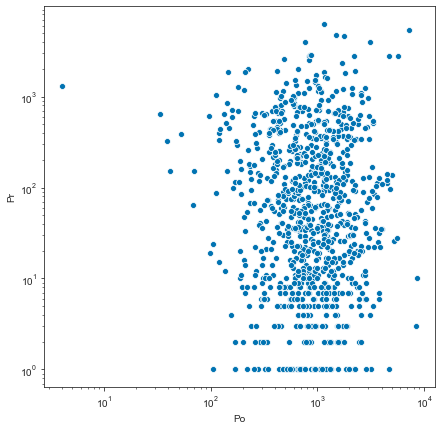

In [6]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Po", y="Pr", data=rec_org_plays)
plt.savefig("../../results/plays_rec_org_loglog.pdf")

## So/Po vs Sr/Pr -- changed in ternary

In [6]:
print("Computing diversity ratio...")
edi_data = get_songs_data(data, origin="edit")
org_data = get_songs_data(data, origin="orga")
alg_data = get_songs_data(data, origin="algo")

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
org_data = org_data.to_frame()
edi_data = edi_data.to_frame()
alg_data = alg_data.to_frame()

org_data.index.names = ["user"]
edi_data.index.names = ["user"]
alg_data.index.names = ["user"]

org_data.columns = ["ratio"]
edi_data.columns = ["ratio"]
alg_data.columns = ["ratio"]

org_data["origin"] = "orga"
edi_data["origin"] = "edit"
alg_data["origin"] = "algo"

# Should definitely not use org_data as a name for all data but dang how I don't wanna reformat all the code below
org_data = pd.concat([org_data, edi_data, alg_data])
org_data = org_data.reset_index()

org_data

Computing diversity ratio...
Organizing data...


,user,ratio,origin
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,0.289855,orga
1,000f74e758dc95d4f10bcc30e94c294dab14fe6f,0.253329,orga
2,00111b3c8e65d6f1238747f1b3ac2a9acf931400,0.193982,orga
3,0012d9783ec39191c1712e16a53726619798390e,0.066612,orga
4,0017c2c4addf980a77f33a110adbc874a4bacff6,0.330126,orga
...,...,...,...
23391,ffda9ab0659751c81b9f2ceb3d080b41dd9f063a,0.362282,algo
23392,ffe04a9a7a7cfa81d78f30f2c902b700ed20d959,0.500547,algo
23393,ffeacc108cd39b36cbb8a667631e1a9f3d408ddd,0.542333,algo
23394,ffee7b654a5a3b9a09f106aaf4a40e1a948f6509,0.673307,algo


In [ ]:
# Remove singletons
# org_data = org_data[org_data.groupby("user").user.transform(len) > 2]
# org_data

In [7]:
# Adding user bins
u_bins = pd.read_csv("../../data/user_bins.csv")
u_bins.columns = ["user", "u_bin_nb", "plays"]
org_data = org_data.merge(u_bins, on="user")
org_data

,user,ratio,origin,u_bin_nb,plays
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,0.289855,orga,2,2242
1,000917cdc11c2f5bdf73080e977c2164dd3317e7,0.533220,edit,2,2242
2,000917cdc11c2f5bdf73080e977c2164dd3317e7,0.911765,algo,2,2242
3,000f74e758dc95d4f10bcc30e94c294dab14fe6f,0.253329,orga,2,7462
4,000f74e758dc95d4f10bcc30e94c294dab14fe6f,0.445674,edit,2,7462
...,...,...,...,...,...
23391,e2f468bfc5ee693915880f67a02629b8e17f3e24,0.620690,edit,3,116
23392,139d0f14209857f5d3b012540b702e11b8ddeb3a,0.258791,algo,4,2929
23393,1b76e21b3a382abc40b045c3f27f5e842ab4d6f7,0.763441,algo,4,186
23394,80c6d5137dd97b70dcbae7c0d25394e0d25ee833,0.469565,algo,4,115


In [8]:
org_data.groupby("user").size().value_counts()

3    6939
2    1133
1     313
dtype: int64

In [9]:
# Grouping data into one df
ratio_data = org_data[org_data["recommended"] == 0].merge(org_data[org_data["recommended"] == 1][["user", "ratio"]], on="user").drop("recommended", axis=1)
ratio_data.columns = ["user", "ratio_org", "rate", "plays", "bin_u", "ratio_rec"]
ratio_data

KeyError: 'recommended'

In [11]:
org_data["logplays"] = org_data["plays"].map(np.log)
org_data["quantile"] = pd.cut(org_data["ratio"], np.arange(0, 1.05, 0.1))
sp_list = org_data.groupby(["u_bin_nb", "origin", "quantile"]).size().to_frame().reset_index()
sp_list["logplays"] = org_data.groupby(["u_bin_nb", "origin", "quantile"])["logplays"].mean().to_frame().reset_index()["logplays"]

sp_list.to_csv("../../data/sp_data.csv", index=False)
sp_list

,u_bin_nb,origin,quantile,0,logplays
0,1,algo,"(0.0, 0.1]",1,9.570320
1,1,algo,"(0.1, 0.2]",0,NaN
2,1,algo,"(0.2, 0.3]",5,9.280085
3,1,algo,"(0.3, 0.4]",23,9.289600
4,1,algo,"(0.4, 0.5]",65,9.033606
...,...,...,...,...,...
115,4,orga,"(0.5, 0.6]",179,8.315130
116,4,orga,"(0.6, 0.7]",149,7.898569
117,4,orga,"(0.7, 0.8]",93,7.590594
118,4,orga,"(0.8, 0.9]",58,7.045443


In [14]:
x = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["ratio"]
y = org_data[org_data["recommended"] == 1].reset_index().drop("index", axis=1)["ratio"]
classes = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["u_bin_nb"].rename(r"bin\_u")

classes.groupby(classes).size()

bin\_u
1    176
2    264
3    286
4    212
Name: bin\_u, dtype: int64

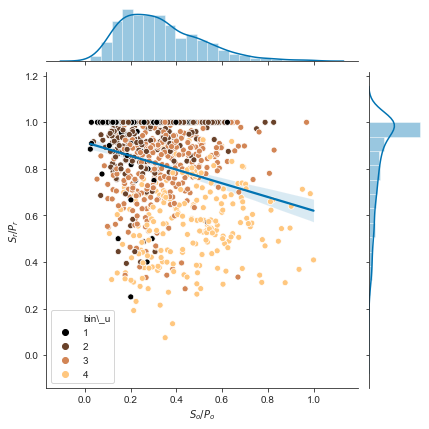

In [15]:
sns.jointplot(x, y, kind='reg', scatter=False)
ax = sns.scatterplot(x, y, hue=classes, palette="copper")
ax.set(xlabel=r"$S_o/P_o$", ylabel=r"$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_17rec_83org.pdf")

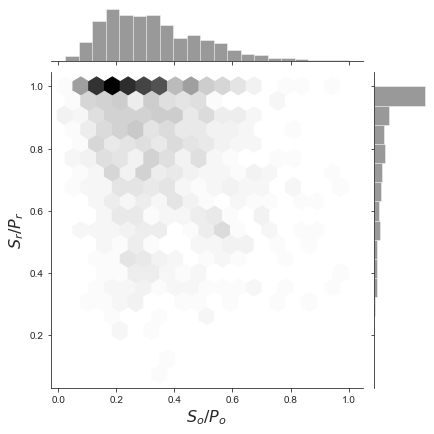

In [13]:
h = sns.jointplot(x, y, kind='hex', color="k")
h.set_axis_labels(r"$S_o/P_o$", r"$S_r/P_r$", fontsize=16)
plt.savefig("../../results/sp_ratio_ratio_hex.pdf")

In [14]:
ratio_data["quantile_org"] = pd.cut(ratio_data["ratio_org"], 5)
ratio_data["quantile_rec"] = pd.cut(ratio_data["ratio_rec"], 5)
ratio_means = ratio_data.groupby(["quantile_org", "bin_u"]).mean()["ratio_rec"].to_frame().reset_index().drop("quantile_org", axis=1)
ratio_means["ratio_org"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means_vert = ratio_data.groupby(["quantile_rec", "bin_u"]).mean()["ratio_org"].to_frame().reset_index().drop("quantile_rec", axis=1)
ratio_means_vert["ratio_rec"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means.columns = ["bin_u", "ratiorectot", "ratioorgtot"]
ratio_means_vert.columns = ["bin_u", "ratioorgvert", "ratiorecvert"]

ratio_data = ratio_data.append(ratio_means, ignore_index=True)
ratio_data = ratio_data.append(ratio_means_vert, ignore_index=True)
ratio_data

,user,ratio_org,rate,plays,bin_u,ratio_rec,quantile_org,quantile_rec,ratiorectot,ratioorgtot,ratioorgvert,ratiorecvert
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0.456532,4164.0,4,0.375592,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0.179395,2514.0,3,0.532151,"(0.219, 0.414]","(0.445, 0.63]",NaN,NaN,NaN,NaN
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0.003861,1295.0,1,0.400000,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.384513,0.173289,1812.0,3,0.904459,"(0.219, 0.414]","(0.815, 1.0]",NaN,NaN,NaN,NaN
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512291,0.117953,1153.0,3,0.772059,"(0.414, 0.61]","(0.63, 0.815]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
973,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,0.491316,0.7
974,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.225638,0.9
975,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0.286218,0.9
976,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,0.385537,0.9


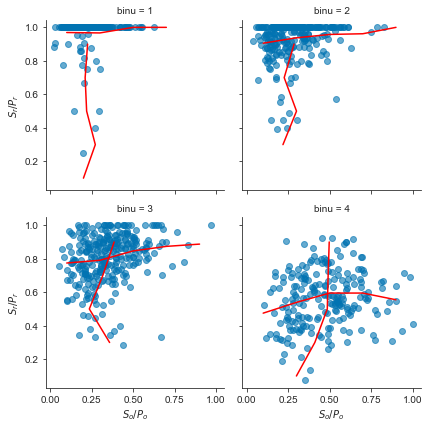

In [15]:
# Workaround to avoid LaTeX explosion
ratio_data.columns = ["user", "ratioorg", "rate", "plays", "binu", "ratiorec", "quantileorg", "quantilerec", "ratiorectot", "ratioorgtot", "ratioorgvert", "ratiorecvert"]

g = sns.FacetGrid(ratio_data, col="binu", col_wrap=2)
g.map(plt.scatter, "ratioorg", "ratiorec", alpha=0.6)
g.map(sns.lineplot, "ratioorgtot", "ratiorectot", color="r")
g.map(sns.lineplot, "ratioorgvert", "ratiorecvert", color="r", sort=False)
g.axes[2].set_xlabel("$S_o/P_o$")
g.axes[3].set_xlabel("$S_o/P_o$")
g.axes[2].set_ylabel("$S_r/P_r$")
g.axes[0].set_ylabel("$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_distinct.pdf")

# sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)

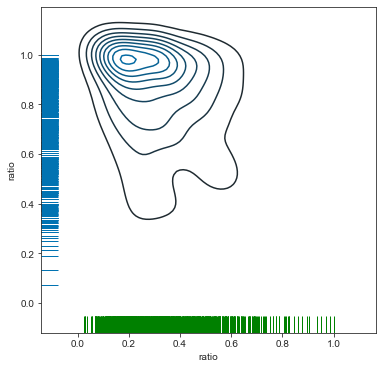

In [16]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);

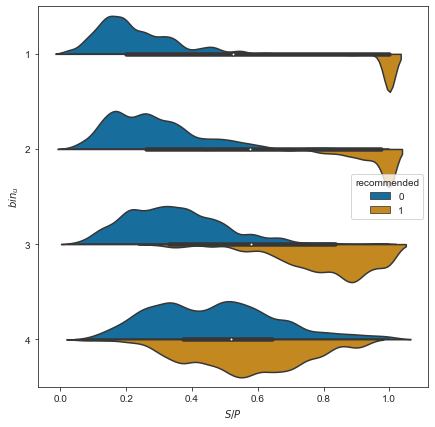

In [19]:
org_data["u_bin_nb"] = org_data["u_bin_nb"].astype('category')
f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(x="ratio", y="ubin", hue="recommended",  scale="count", scale_hue=True, data=org_data.rename(columns={"u_bin_nb": "ubin"}), split=True, bw=0.17, inner="box")
ax.set(ylabel="$bin_u$", xlabel="$S/P$")
plt.savefig("../../results/sp_ratio_violin_bin_u_pdist.png")

In [9]:
# Getting total S/P ratio for each user
print("Computing diversity ratio...")
sp_data = get_songs_data(data)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
sp_data = sp_data.to_frame()
sp_data.index.names = ["user"]
sp_data.columns = ["ratio"]

# Adding user bins and plays
sp_data = user_bin_data.merge(sp_data, left_on="user_id", right_on="user")
sp_data = sp_data.merge(data.groupby("user_id").size().to_frame(), on="user_id").rename(columns={0: "plays"})
sp_data

Computing diversity ratio...


KeyboardInterrupt: 

In [8]:
sp_data.to_csv("../../data/sp_ratios_full.csv", index=False)

In [10]:
sp_data = pd.read_csv("../../data/sp_ratios_full.csv")

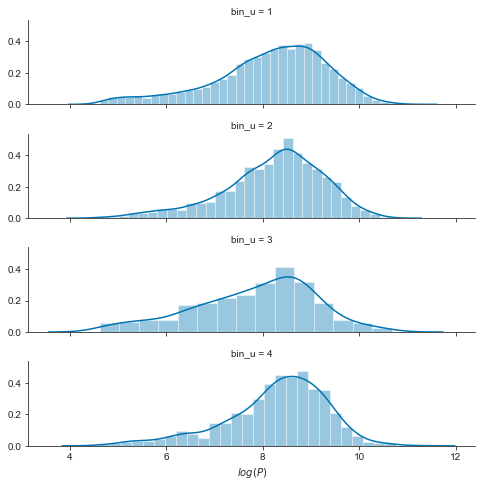

In [7]:
sp_data["logplays"] = sp_data["plays"].map(np.log)
g = sns.FacetGrid(sp_data, row="bin_u", height=1.7, aspect=4)
g.map(sns.distplot, "logplays")
g.axes[3, 0].set_xlabel("$log(P)$")
plt.savefig("../../results/pdist_ubins.pdf")

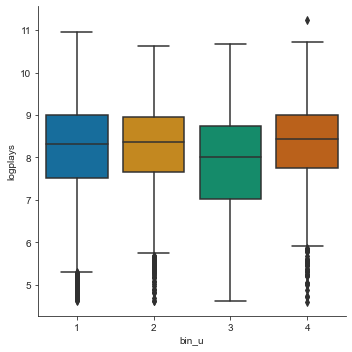

In [12]:
sns.catplot(x="bin_u", y="logplays", data=sp_data, kind="box")
plt.savefig("../../results/pdist_ubins_box.pdf")

In [22]:
# f, ax = plt.subplots(figsize=(7, 7))
# h = sns.jointplot(x="rate", y="ratio", data=sp_data, alpha=0.6)
# sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)
# h.set_axis_labels(r'$\rho$', r'$S/P$', fontsize=16)
# plt.savefig("../../results/sp_rho_scatter_meanbins.pdf")

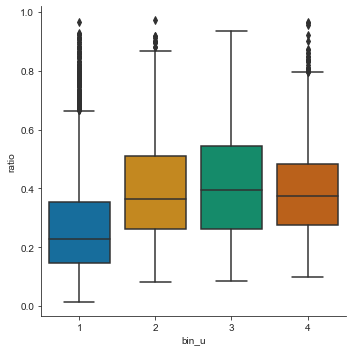

In [11]:
sns.catplot(x="bin_u", y="ratio", data=sp_data, kind="box")
plt.savefig("../../results/sp_ubins.pdf")

In [18]:
sp_data["logplays"] = sp_data["plays"].map(np.log)
sp_data["quantile"] = pd.cut(sp_data["logplays"], np.arange(4.5, 12.5, 1))

plays_means = sp_data.groupby(["bin_u", "quantile"]).mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)
plays_means["logplays"] = list(np.arange(5, 12, 1)) * 4
plays_means

,bin_u,ratio,logplays
0,1,0.479125,5
1,1,0.429823,6
2,1,0.354933,7
3,1,0.280049,8
4,1,0.208939,9
5,1,0.139526,10
6,1,0.086943,11
7,2,0.680869,5
8,2,0.609628,6
9,2,0.521821,7


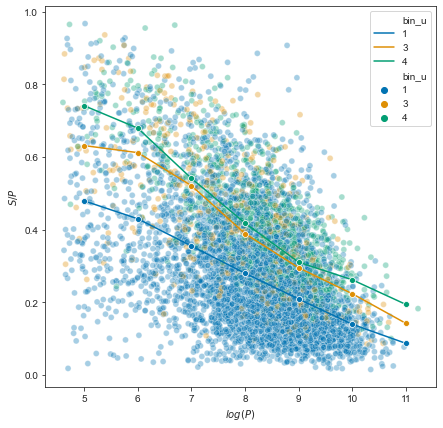

In [39]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="logplays", y="ratio", hue="bin_u", data=sp_data[sp_data["bin_u"] != 2], alpha=.35, palette=sns.color_palette("colorblind", 3))
sns.lineplot(x="logplays", y="ratio", data=plays_means[plays_means["bin_u"] != 2], hue="bin_u", marker= "o", palette=sns.color_palette("colorblind", 3))
ax.set(ylabel="$S/P$", xlabel="$log(P)$")
plt.savefig("../../results/sp_logp_bins.pdf")

## S/P and mainstream?

In [15]:
bin_mu_delta = data.rename(columns={"bin_nb": "bin_mn"}).groupby("user_id").mean()["bin_mn"] - 2
bin_mu_delta = bin_mu_delta.to_frame().reset_index()
bin_mu_delta = bin_mu_delta.merge(sp_data[["user_id", "ratio", "plays"]], on="user_id")
bin_mu_delta

,user_id,bin_mn,ratio,plays
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,-0.257360,0.328278,2242
1,000f74e758dc95d4f10bcc30e94c294dab14fe6f,0.359287,0.275529,7462
2,00111b3c8e65d6f1238747f1b3ac2a9acf931400,1.016247,0.218498,7817
3,0012d9783ec39191c1712e16a53726619798390e,0.494584,0.068056,4893
4,0017c2c4addf980a77f33a110adbc874a4bacff6,0.332913,0.346018,3968
...,...,...,...,...
8380,ffda9ab0659751c81b9f2ceb3d080b41dd9f063a,0.536018,0.384189,5414
8381,ffe04a9a7a7cfa81d78f30f2c902b700ed20d959,1.253227,0.539346,5655
8382,ffeacc108cd39b36cbb8a667631e1a9f3d408ddd,0.806351,0.469400,8660
8383,ffee7b654a5a3b9a09f106aaf4a40e1a948f6509,1.547702,0.323468,2872


In [16]:
sp_mu_bins = np.arange(bin_mu_delta["bin_mn"].min(), bin_mu_delta["bin_mn"].max()+0.1, (bin_mu_delta["bin_mn"].max()-bin_mu_delta["bin_mn"].min()) / 4)
sp_mu_bins
bin_mu_delta["quantile"] = pd.cut(bin_mu_delta["bin_mn"], sp_mu_bins)

sp_mu_means = bin_mu_delta.groupby(["quantile"]).mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)

sp_mu_bins_points = []
for i in range(sp_mu_bins.size - 1):
    sp_mu_bins_points.append((sp_mu_bins[i] + sp_mu_bins[i+1]) / 2)

sp_mu_means["bin_mn"] = sp_mu_bins_points
sp_mu_means

,ratio,bin_mn
0,0.213566,-0.625
1,0.280245,0.125
2,0.375458,0.875
3,0.438782,1.625


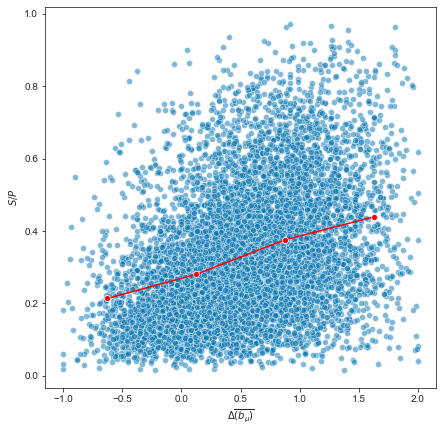

In [19]:
f, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="bin_mn", y="ratio", data=bin_mu_delta, alpha=0.5)
sns.lineplot(x="bin_mn", y="ratio", data=sp_mu_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$\Delta\overline{(b_\mu)}$")

plt.savefig("../../results/sp_deltamu.pdf")

In [57]:
sp_binned = get_sp_binned(data.rename(columns={"bin_nb": "bin_mn"}), obs_threshold=15).to_frame().reset_index()
sp_binned

,user_id,bin_mn,0
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,1,0.190689
1,000917cdc11c2f5bdf73080e977c2164dd3317e7,2,0.389592
2,000917cdc11c2f5bdf73080e977c2164dd3317e7,3,0.489583
3,000917cdc11c2f5bdf73080e977c2164dd3317e7,4,0.833333
4,000f74e758dc95d4f10bcc30e94c294dab14fe6f,1,0.185143
...,...,...,...
32867,ffee7b654a5a3b9a09f106aaf4a40e1a948f6509,4,0.348827
32868,fff7883b935e4eeac717db3ce601a6012584c184,1,0.475570
32869,fff7883b935e4eeac717db3ce601a6012584c184,2,0.406907
32870,fff7883b935e4eeac717db3ce601a6012584c184,3,0.467717


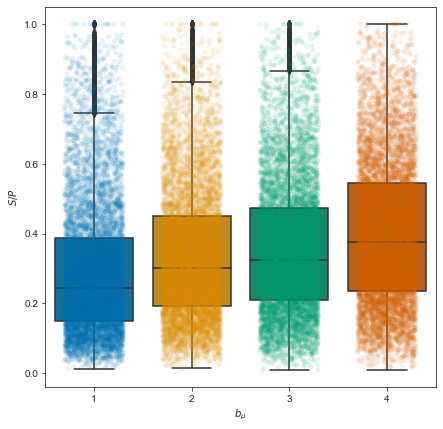

In [60]:
f, ax = plt.subplots(figsize=(7, 7))

sns.stripplot(x="bin_mn", y=0, data=sp_binned, jitter=.3, alpha=.1)
sns.boxplot(x="bin_mn", y=0, data=sp_binned)

ax.set(ylabel="$S/P$", xlabel="$b_\mu$")
plt.savefig("../../results/sp_binmu_sep.pdf")
# sns.violinplot(x="bin_mn", y=0, data=sp_binned)

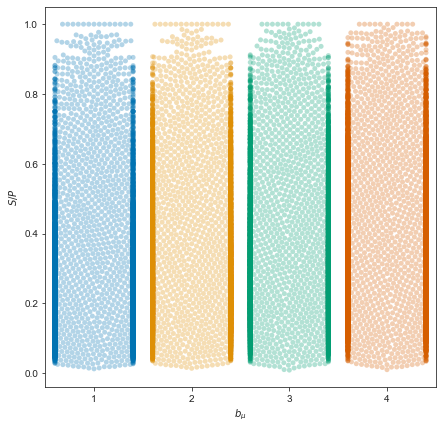

In [61]:
f, ax = plt.subplots(figsize=(7, 7))

sns.swarmplot(x="bin_mn", y=0, data=sp_binned, alpha=.3)
ax.set(ylabel="$S/P$", xlabel="$b_\mu$")
plt.savefig("../../results/sp_binmu_sep_swarm.pdf")

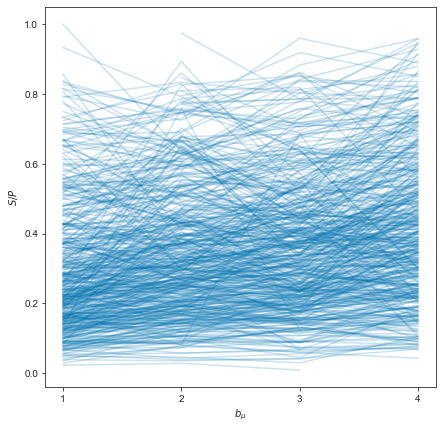

In [63]:
# Manual bootstrap sampling of users
sample_size = 500
user_sample = np.random.choice(sp_binned["user_id"].unique(), sample_size)

f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x="bin_mn", y=0, units="user_id", estimator=None,
             data=sp_binned[sp_binned["user_id"].isin(user_sample)], alpha=0.2)

ax.set(ylabel="$S/P$", xlabel="$b_\mu$")
ax.set_xticks(np.arange(1,5,1))
plt.savefig("../../results/sp_binmu_lines.pdf")